# CrossFit Retention Project — 02 Modeling
Build a simple churn model to identify at-risk members using PushPress exports.

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd

# Define file paths
CURRENT_DIR = os.path.abspath("..")
RAW_DATA_DIR = os.path.join(CURRENT_DIR, "data", "raw")
MEMBERS_CSV = os.path.join(RAW_DATA_DIR, "Members.csv")
ATTENDANCE_CSV = os.path.join(RAW_DATA_DIR, "Attendance.csv")
SALES_CSV = os.path.join(RAW_DATA_DIR, "Store_Sales.csv")
CANCELLATIONS_CSV = os.path.join(RAW_DATA_DIR, "Cancellations.csv")

# Load datasets with date parsing
members = pd.read_csv(MEMBERS_CSV, parse_dates=["Join_Date"])
attendance = pd.read_csv(ATTENDANCE_CSV, parse_dates=["Date"])
sales = pd.read_csv(SALES_CSV, parse_dates=["Purchase_Date"])
cancellations = pd.read_csv(CANCELLATIONS_CSV, parse_dates=["Cancel_Date"])

members.head(3), attendance.head(3), sales.head(3), cancellations.head(3)

(   Member_ID First_Name  Join_Date Membership_Type Referral_Source
 0          1    Member1 2024-11-23      Punch Card          Friend
 1          2    Member2 2024-02-27     Foundations          Friend
 2          3    Member3 2024-01-13       Unlimited          Google,
    Member_ID       Date     Class_Type    Coach      Status
 0          1 2025-06-06       Open Gym  Coach D  Checked In
 1          1 2025-02-23       CrossFit  Coach C  Checked In
 2          1 2025-08-30  Weightlifting  Coach C  Checked In,
    Member_ID Purchase_Date                Item  Amount_USD
 0          1    2025-09-09      Protein Powder       28.91
 1          1    2025-08-14       Shaker Bottle       84.26
 2          1    2025-02-01  Membership Upgrade      113.31,
    Member_ID Cancel_Date
 0        204  2025-05-11
 1        267  2025-04-16
 2        153  2024-07-23)

## Feature Engineering

In [9]:
# Snapshot date = most recent attendance date
snapshot_date = attendance["Date"].max()

# Attendance-based features
att_ok = attendance[attendance["Status"].eq("Checked In")].copy()
last_seen = att_ok.groupby("Member_ID")["Date"].max().rename("Last_Checkin")
first_seen = att_ok.groupby("Member_ID")["Date"].min().rename("First_Checkin")
totals = att_ok.groupby("Member_ID").size().rename("Total_Checkins")
by_month = att_ok.assign(month=att_ok["Date"].dt.to_period("M").dt.to_timestamp())
visits_monthly = by_month.groupby(["Member_ID", "month"]).size().rename("Visits_Month")

# Variability of attendance
var_att = visits_monthly.groupby("Member_ID").std().rename("Visits_Month_STD")

# Recency + frequency
feats = members.set_index("Member_ID").join(last_seen).join(first_seen).join(totals).reset_index()
feats["Days_Since_Last"] = (snapshot_date - feats["Last_Checkin"]).dt.days
feats["Months_Active"] = (
    (feats["Last_Checkin"].dt.to_period("M") - feats["First_Checkin"].dt.to_period("M")).apply(
        lambda p: p.n
    )
    + 1
).clip(lower=1)
feats["Visits_per_Month"] = (feats["Total_Checkins"] / feats["Months_Active"]).fillna(0)

# Retail spend
spend = sales.groupby("Member_ID")["Amount_USD"].sum().rename("Retail_Spend_USD")
feats = feats.set_index("Member_ID").join(spend).reset_index().fillna({"Retail_Spend_USD": 0})

# Membership dummies
feats = pd.get_dummies(feats, columns=["Membership_Type", "Referral_Source"], drop_first=True)

# Label churned (historical)
churn_ids = set(cancellations["Member_ID"])
feats["Churned"] = feats["Member_ID"].isin(churn_ids).astype(int)

# Join variability feature
feats = feats.set_index("Member_ID").join(var_att).reset_index()

# Fill NaNs for variability and recency features
feats["Visits_Month_STD"] = feats["Visits_Month_STD"].fillna(0)
feats["Days_Since_Last"] = feats["Days_Since_Last"].fillna(
    (snapshot_date - members["Join_Date"].min()).days
)
feats["Visits_per_Month"] = feats["Visits_per_Month"].fillna(0)

# Drop leakage columns
drop_cols = ["First_Checkin", "Last_Checkin", "Join_Date"]
feats = feats.drop(columns=[c for c in drop_cols if c in feats.columns])
feats.head()

,Member_ID,First_Name,Total_Checkins,Days_Since_Last,Months_Active,Visits_per_Month,Retail_Spend_USD,Membership_Type_Foundations,Membership_Type_Punch Card,Membership_Type_Unlimited,Referral_Source_Friend,Referral_Source_Google,Referral_Source_Instagram,Referral_Source_Walk-in,Churned,Visits_Month_STD
0,1,Member1,85,0,12,7.083333,311.75,False,True,False,True,False,False,False,0,3.679386
1,2,Member2,94,2,19,4.947368,343.90,True,False,False,True,False,False,False,0,2.344584
2,3,Member3,80,2,21,3.809524,625.86,False,False,True,False,True,False,False,0,2.315579
3,4,Member4,68,0,10,6.800000,539.33,False,True,False,False,False,True,False,0,3.155243
4,5,Member5,77,0,18,4.277778,569.10,False,True,False,False,False,False,True,0,2.217724


## Train/Test Split & Baselines

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

target = "Churned"
X = feats.drop(columns=[target, "Member_ID", "First_Name"])
y = feats[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print(f"Logistic ROC AUC: {lr_auc:.3f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
print(f"RandomForest ROC AUC: {rf_auc:.3f}")

Logistic ROC AUC: 0.543
RandomForest ROC AUC: 0.442
RandomForest ROC AUC: 0.442


## Curves (one plot per figure)

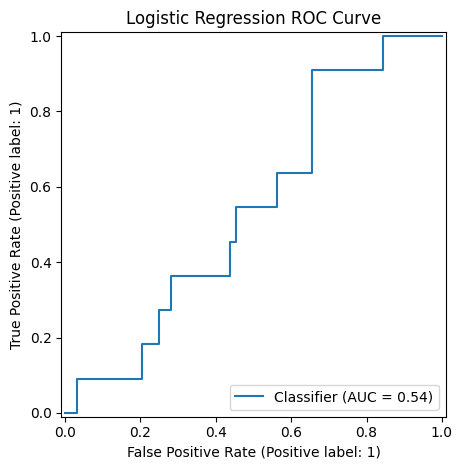

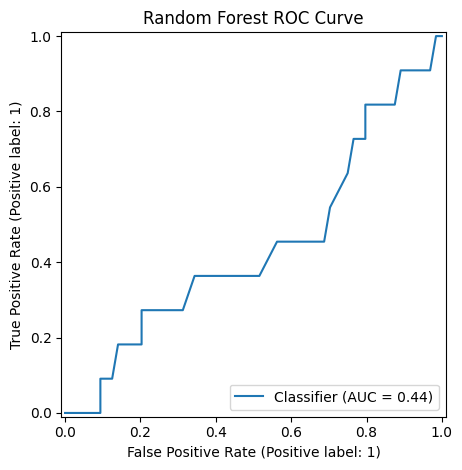

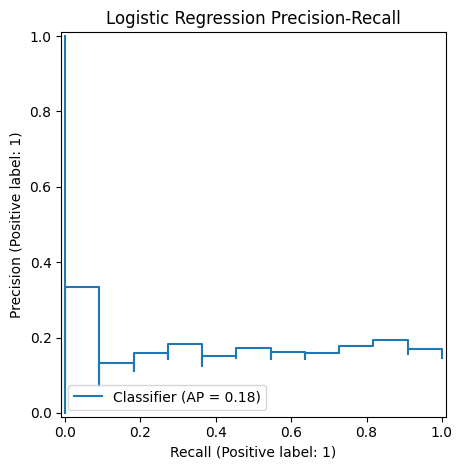

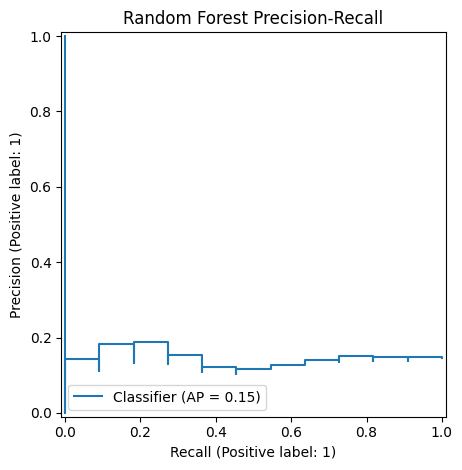

In [11]:
RocCurveDisplay.from_predictions(y_test, lr_probs)
plt.title("Logistic Regression ROC Curve")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, rf_probs)
plt.title("Random Forest ROC Curve")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, lr_probs)
plt.title("Logistic Regression Precision-Recall")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, rf_probs)
plt.title("Random Forest Precision-Recall")
plt.tight_layout()
plt.show()

## Thresholding & Confusion Matrix

Random Forest Threshold: 0.4
              precision    recall  f1-score   support

           0      0.849     0.969     0.905        64
           1      0.000     0.000     0.000        11

    accuracy                          0.827        75
   macro avg      0.425     0.484     0.453        75
weighted avg      0.725     0.827     0.772        75



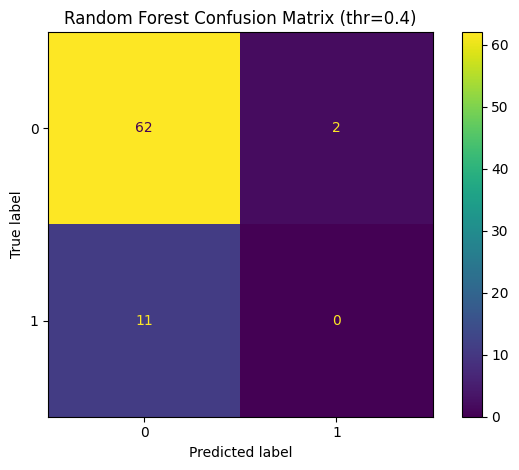

Logistic Regression Threshold: 0.4
              precision    recall  f1-score   support

           0      0.851     0.984     0.913        64
           1      0.000     0.000     0.000        11

    accuracy                          0.840        75
   macro avg      0.426     0.492     0.457        75
weighted avg      0.726     0.840     0.779        75



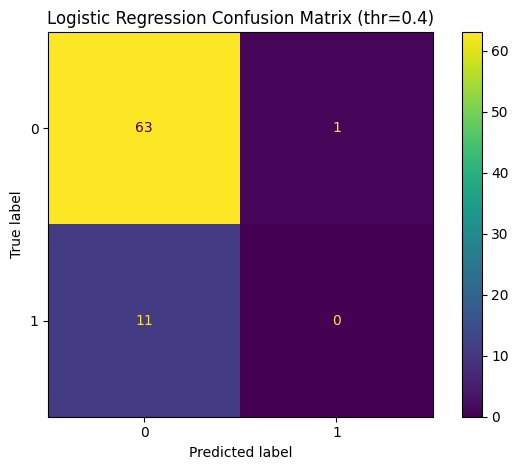

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay


def evaluate_threshold(probs, y_true, threshold=0.5, title="Model"):
    preds = (probs >= threshold).astype(int)
    print(title, "Threshold:", threshold)
    print(classification_report(y_true, preds, digits=3))
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{title} Confusion Matrix (thr={threshold})")
    plt.tight_layout()
    plt.show()


evaluate_threshold(rf_probs, y_test, threshold=0.4, title="Random Forest")
evaluate_threshold(lr_probs, y_test, threshold=0.4, title="Logistic Regression")

## Feature Importance & Top Risk List

,Importance
Retail_Spend_USD,0.174511
Visits_Month_STD,0.168566
Visits_per_Month,0.157263
Total_Checkins,0.132870
Days_Since_Last,0.126239
Months_Active,0.097132
Membership_Type_Foundations,0.030520
Referral_Source_Instagram,0.022875
Membership_Type_Punch Card,0.022439
Referral_Source_Friend,0.018596


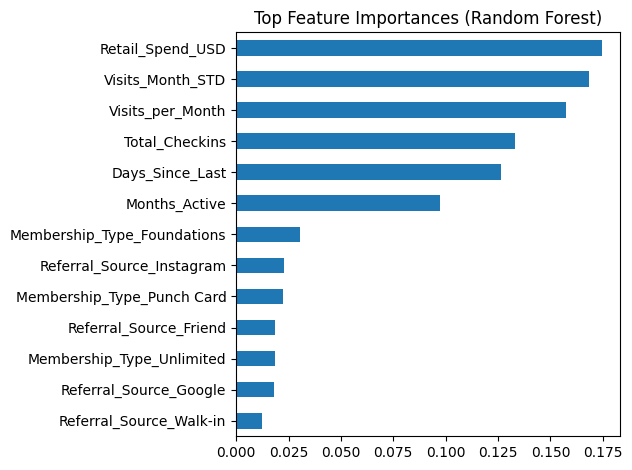

,Member_ID,Days_Since_Last,Visits_per_Month,Retail_Spend_USD,Churn_Risk_Score
16,17,13,3.190476,322.23,0.460000
223,224,9,4.187500,320.47,0.443333
252,253,5,4.611111,279.52,0.393333
197,198,15,3.888889,637.10,0.380000
267,268,4,4.047619,308.78,0.353333
56,57,14,4.529412,474.28,0.333333
62,63,3,4.368421,261.95,0.306667
261,262,4,4.500000,685.89,0.303333
21,22,7,3.615385,594.60,0.300000
122,123,1,3.666667,495.19,0.280000


In [13]:
# Random Forest feature importance
import pandas as pd

fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(fi.head(15).to_frame("Importance"))

plt.figure()
fi.head(15).sort_values().plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# Create a scored list of current members (inference on whole set)
rf_all_probs = rf.predict_proba(X)[:, 1]
scored = feats.copy()
scored["Churn_Risk_Score"] = rf_all_probs
# Example outreach list: the top 10 at-risk active members
active_ids = set(members["Member_ID"]) - set(cancellations["Member_ID"])
outreach = (
    scored[scored["Member_ID"].isin(active_ids)]
    .sort_values("Churn_Risk_Score", ascending=False)
    .head(10)
)
display(
    outreach[
        ["Member_ID", "Days_Since_Last", "Visits_per_Month", "Retail_Spend_USD", "Churn_Risk_Score"]
    ]
)

### Notes for the Owner
- Members with **high days since last visit** and **low visits per month** trend higher risk.
- Consider personal coach outreach at 10–14 days inactive, plus a community nudge (buddy text, event invite).